**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
            
        augmented = self.transform(image=image,
                                   mask=mask)
        sample = {}
        sample['image'] = augmented['image']
        sample['mask'] = augmented['mask']

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.RandomGamma(p=0.5),
#     A.OneOf([
#         A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
#         A.GridDistortion(p=0.5),
#         A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
#         ], p=0.8),
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 512, 512]) torch.Size([512, 512])


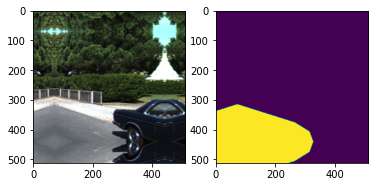

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

print(image.shape, mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

### Model U-Net

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, mid_channels=None, padding='same'):
        super().__init__()
        
        if mid_channels is None:
            mid_channels = output_channels
            
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=mid_channels,
                               kernel_size=(3, 3),
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=output_channels,
                               kernel_size=(3, 3),
                               padding=padding)
        
        self.dropout2d = nn.Dropout2d(0.1)
        self.use_dropout = False
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        
        if self.use_dropout:
            x = self.dropout2d(x)
        
        return x

In [8]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [9]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_layer = ConvLayer(input_channels, output_channels, input_channels // 2)
        self.conv_transposed = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)
#         self.upscaler = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    
    def forward(self, x1, x2):
        x1 = self.conv_transposed(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv_layer(x)
        
        return x
        

In [10]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 32
        self.n_classes = 1
        
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        self.down1 = DownScaller(self.output_channel * 1, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8)
        self.down4 = DownScaller(self.output_channel * 8, self.output_channel * 16)
        self.down5 = DownScaller(self.output_channel * 16, self.output_channel * 32)
        
        self.up1 = UpScaler(self.output_channel * 32, self.output_channel * 16)
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        self.up5 = UpScaler(self.output_channel * 2, self.output_channel * 1)

        self.conv3 = nn.Conv2d(self.output_channel * 1, self.n_classes, kernel_size=(3, 3), padding='same')
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        x_5 = self.down4(x_4)
        x_6 = self.down5(x_5)

        x_7 = self.up1(x_6, x_5)
        x_8 = self.up2(x_7, x_4)      
        x_9 = self.up3(x_8, x_3)
        x_10 = self.up4(x_9, x_2)
        x_11 = self.up5(x_10, x_1)
        
        output = self.conv3(x_11)
        
        return output
        
        
        

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 512, 512])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 512, 512])


### Train U-Net

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
summary(model, input_size=train_dataset[0]['image'].shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
         ConvLayer-7         [-1, 32, 512, 512]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14         [-1, 64, 2

In [13]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / (union + 1e-10)


def calc_dice(pred, target, alpha = 1.):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice


def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
    bce_loss = F.binary_cross_entropy_with_logits(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
                                                 )
    dice_loss = 1 - calc_dice(pred, target)
    
    loss = bce_loss + dice_loss
    
    return loss

In [14]:
def train_model(model, data_loader, optimizer):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(tqdm(data_loader), 1):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output.cpu().detach().numpy(), 
                                    y_batch.cpu().detach().numpy()))
#         if i % 50 == 0:
#             print(loss_history[-1], iou_history[-1])
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')
    
    return model

In [15]:
@torch.no_grad()
def eval_model(model, data_loader):
    loss_history = []
    iou_history = []
    
    for i, batch in enumerate(data_loader, 1):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output.cpu().detach().numpy(), 
                                    y_batch.cpu().detach().numpy()))
        
#         if i % 50 == 0:
#             print(loss_history[-1], iou_history[-1])

    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}\n')
    
    image = train_dataset[0]['image'].to(device).float()
    pred_mask = model(image[None, :, :, :])
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [16]:
BATCH_SIZE = 3
EPOCHS = 20
learning_rate = 0.001

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

EPOCH:   0%|          | 0/20 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -4.102 ± 165.032            IoU: 0.285  ± 0.199
VALID
Loss: 2.216 ± 4.553            IoU: 0.399  ± 0.221



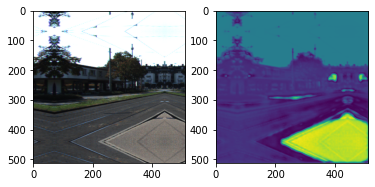

-------------------------------------------------- Epoch 2 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -33.411 ± 380.059            IoU: 0.170  ± 0.139
VALID
Loss: 1.469 ± 4.429            IoU: 0.261  ± 0.161



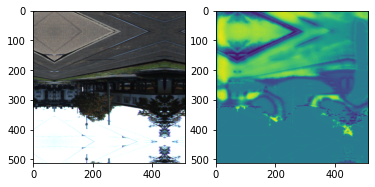

-------------------------------------------------- Epoch 3 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -1.195 ± 2.616            IoU: 0.258  ± 0.096
VALID
Loss: 1.320 ± 2.888            IoU: 0.284  ± 0.164



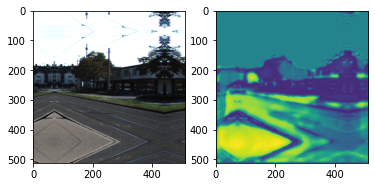

-------------------------------------------------- Epoch 4 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -1.650 ± 12.918            IoU: 0.255  ± 0.105
VALID
Loss: 1.843 ± 2.960            IoU: 0.270  ± 0.157



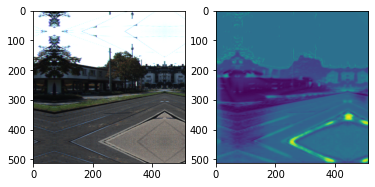

-------------------------------------------------- Epoch 5 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -3.403 ± 7.726            IoU: 0.302  ± 0.105
VALID
Loss: 0.751 ± 3.393            IoU: 0.305  ± 0.173



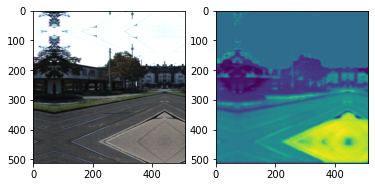

-------------------------------------------------- Epoch 6 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -5.892 ± 8.770            IoU: 0.334  ± 0.115
VALID
Loss: 15.311 ± 121.310            IoU: 0.317  ± 0.178



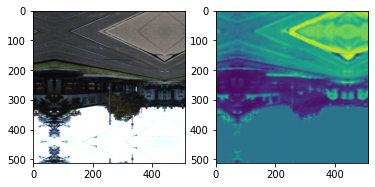

-------------------------------------------------- Epoch 7 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -6.637 ± 12.669            IoU: 0.329  ± 0.130
VALID
Loss: 0.652 ± 5.095            IoU: 0.316  ± 0.176



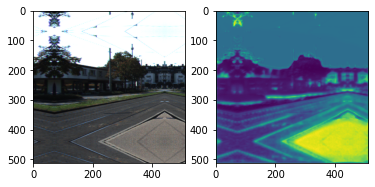

-------------------------------------------------- Epoch 8 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -8.394 ± 13.208            IoU: 0.352  ± 0.131
VALID
Loss: 1.107 ± 13.755            IoU: 0.337  ± 0.187



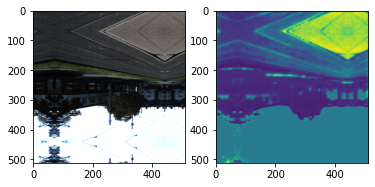

-------------------------------------------------- Epoch 9 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -7.587 ± 14.307            IoU: 0.371  ± 0.141
VALID
Loss: -3.240 ± 29.949            IoU: 0.339  ± 0.188



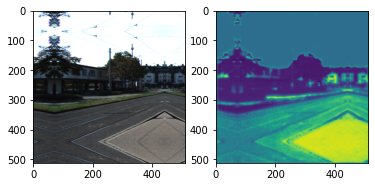

-------------------------------------------------- Epoch 10 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -6.120 ± 12.328            IoU: 0.351  ± 0.128
VALID
Loss: 23.993 ± 195.754            IoU: 0.337  ± 0.187



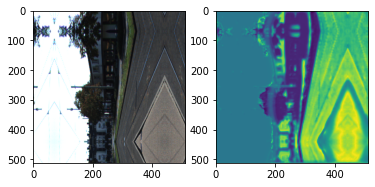

-------------------------------------------------- Epoch 11 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -0.928 ± 31.665            IoU: 0.277  ± 0.124
VALID
Loss: 2.197 ± 7.505            IoU: 0.341  ± 0.204



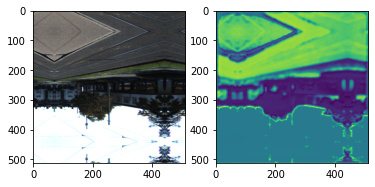

-------------------------------------------------- Epoch 12 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -2.891 ± 12.515            IoU: 0.262  ± 0.122
VALID
Loss: 2.769 ± 15.467            IoU: 0.324  ± 0.176



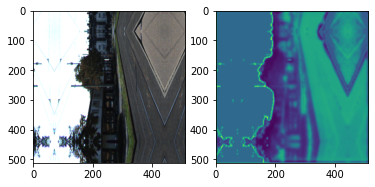

-------------------------------------------------- Epoch 13 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -7.776 ± 13.932            IoU: 0.338  ± 0.139
VALID
Loss: 0.958 ± 3.532            IoU: 0.344  ± 0.191



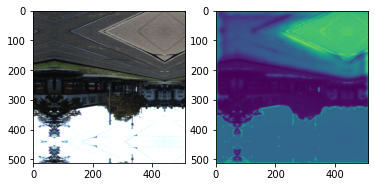

-------------------------------------------------- Epoch 14 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -1.492 ± 56.090            IoU: 0.282  ± 0.147
VALID
Loss: -2.446 ± 32.311            IoU: 0.239  ± 0.190



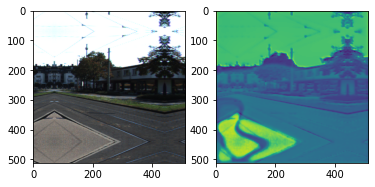

-------------------------------------------------- Epoch 15 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -9.474 ± 36.878            IoU: 0.326  ± 0.140
VALID
Loss: 1.409 ± 2.868            IoU: 0.395  ± 0.233



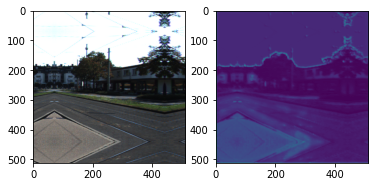

-------------------------------------------------- Epoch 16 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: 4.174 ± 86.766            IoU: 0.285  ± 0.154
VALID
Loss: 0.970 ± 6.225            IoU: 0.335  ± 0.225



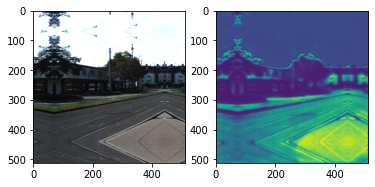

-------------------------------------------------- Epoch 17 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

Loss: -15.282 ± 61.283            IoU: 0.344  ± 0.182
VALID
Loss: 4.642 ± 1.446            IoU: 0.136  ± 0.138



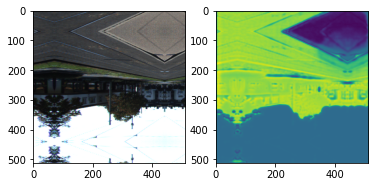

-------------------------------------------------- Epoch 18 / 20 --------------------------------------------------
TRAIN


  0%|          | 0/216 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
torch.cuda.empty_cache()

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
#     print(f'LR = {scheduler.get_last_lr()}')
    
    print('TRAIN')
    model.train(True) 
    model = train_model(model, train_loader, optimizer)
    
    print('VALID')
    model.train(False) 
    eval_model(model, test_loader)
    
#     scheduler.step()
    